In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
import tensorflow as tf

In [2]:
def del_no_pump_index(df):
    """
    Deletes the rows where the pump is not running
    """
    # df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    # 将第一个列设为索引
    orginal = df.shape[0]

    # 找出没有被pump的pump_index
    pump_index = df['pump_index'].unique()
    nopump_index = []
    nopump_symbol = []
    for i in pump_index:
        df_pump = df[df['pump_index'] == i]
        # 如果df_pump的列gt不存在等于1, 打印i
        if 1 not in df_pump['gt'].values:
            nopump_symbol.append(df_pump['symbol'].unique().tolist()[0])
            nopump_index.append(i)
    print('nopump_index: ', nopump_index)
    print('nopump_symbol: ', nopump_symbol)

    print('df.shape: ', df.shape)
    print(df['pump_index'].unique().shape)

    # 删除pump_index的值等于48的行
    for i in nopump_index:
        df = df.drop(df[df['pump_index'] == i].index)

    print('df_cleaned.shape: ', df.shape)
    print(df['pump_index'].unique().shape)
    now = df.shape[0]
    print('deleted: ', orginal - now)
    return df

In [4]:
# --------------------------------------------------------------------------------------------------
def lstm_autoencoder(time_freq):
    df = pd.read_csv('before_pump/before_pump_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    df = del_no_pump_index(df)

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # normal data
    X_normal = X[Y == 0]
    Y_normal = Y[Y == 0]

    # abnormal data
    X_abnormal = X[Y == 1]
    Y_abnormal = Y[Y == 1]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=2023)
    
    # 拼接X_test和X_abnormal
    X_test = np.concatenate((X_test, X_abnormal), axis=0)
    y_test = np.concatenate((y_test, Y_abnormal), axis=0)

    # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # 构建LSTM自编码器模型
    reg = 0.0001
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    encoded = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(reg))(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(X_train.shape[1])(encoded)
    decoded = LSTM(16, activation='relu', return_sequences=True,)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(X_train.shape[2]))(decoded)
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae')
    # adam = optimizers.Adam(learning_rate=0.0001)
    # autoencoder.compile(optimizer=adam, loss='mae')
    # autoencoder.summary()
    
    # 使用训练数据训练LSTM自编码器模型
    early_stopping = EarlyStopping(monitor='val_loss'
                                # , min_delta=0.0001
                                , patience=12
                                , verbose=1
                                # , mode='min'
                                , restore_best_weights=True)
    history= autoencoder.fit(X_train, X_train
                            , epochs=150
                            , batch_size=32
                            , validation_split=0.1
                            , callbacks=[early_stopping]
                            )

    # plot loss curve
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('LSTM-AutoEncoder Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # 使用训练好的LSTM自编码器重构测试数据
    X_test_pred = autoencoder.predict(X_test)
    X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
    testX = X_test.reshape(X_test.shape[0], X_test.shape[2])

    # 计算还原误差MAE
    test_mae = np.mean(np.abs(testX - X_test_pred), axis=1)

    return autoencoder, test_mae, y_test



# --------------------------------------------------------------------------------------------------
def pick_threshold(y, preds):
    thresholds = np.linspace(0, 1, 1000)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold
# ------------------------------set threshold--------------------------------------------------------
def set_threshold(y_test, test_mae, threshold):
    # 设置阈值
    threshold = threshold
    print("Reconstruction error threshold: ", threshold)
    y_test_pred = np.where(test_mae >= threshold , 1, 0)

    # precision, recall, f1-score
    print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))
    print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
    

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# LSTM AutoEncoder

- 25S

nopump_index:  []
nopump_symbol:  []
df.shape:  (182534, 16)
(317,)
df_cleaned.shape:  (182534, 16)
(317,)
deleted:  0
Epoch 1/150
4100/4100 [==============================] - 15s 3ms/step - loss: 0.1541 - val_loss: 0.1025
Epoch 2/150
4100/4100 [==============================] - 11s 3ms/step - loss: 0.0693 - val_loss: 0.0498
Epoch 3/150
4100/4100 [==============================] - 11s 3ms/step - loss: 0.0453 - val_loss: 0.0397
Epoch 4/150
4100/4100 [==============================] - 11s 3ms/step - loss: 0.0338 - val_loss: 0.0353
Epoch 5/150
4100/4100 [==============================] - 11s 3ms/step - loss: 0.0244 - val_loss: 0.0214
Epoch 6/150
4100/4100 [==============================] - 12s 3ms/step - loss: 0.0190 - val_loss: 0.0198
Epoch 7/150
4100/4100 [==============================] - 12s 3ms/step - loss: 0.0181 - val_loss: 0.0176
Epoch 8/150
4100/4100 [==============================] - 12s 3ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 9/150
4100/4100 [==========================

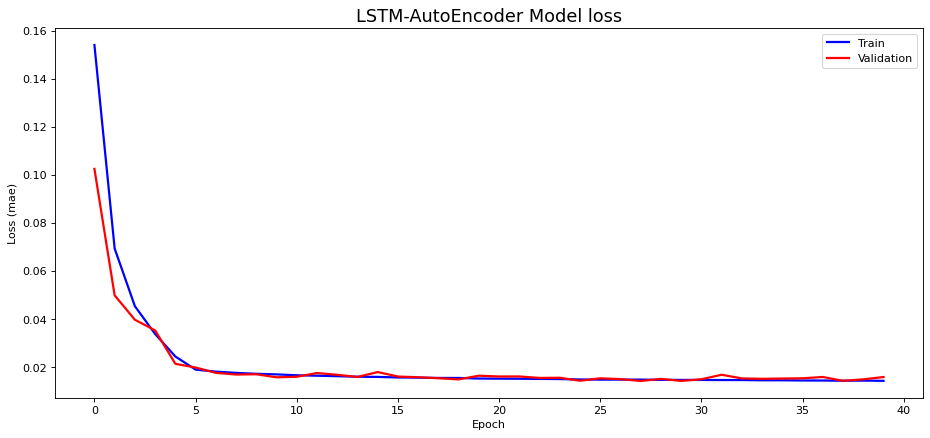

1149/1149 [==============================] - 1s 866us/step


In [5]:
autoencoder_25S, test_mae_25S, y_test_25S = lstm_autoencoder(time_freq='25S') # 6m 51s

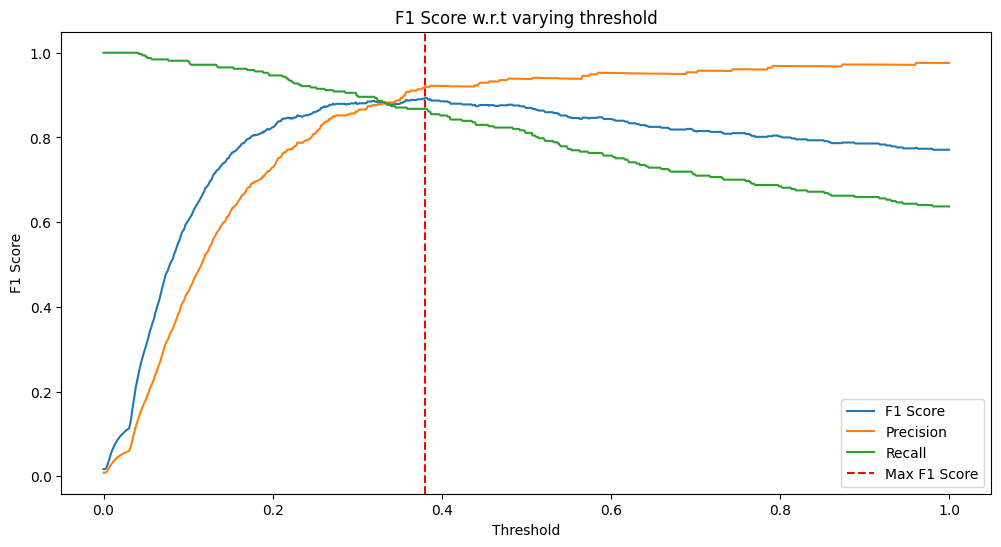

Best threshold:  0.38038038038038036
Best F1 Score:  0.8928571428571429
Recall:  0.8675078864353313
Precision:  0.919732441471572


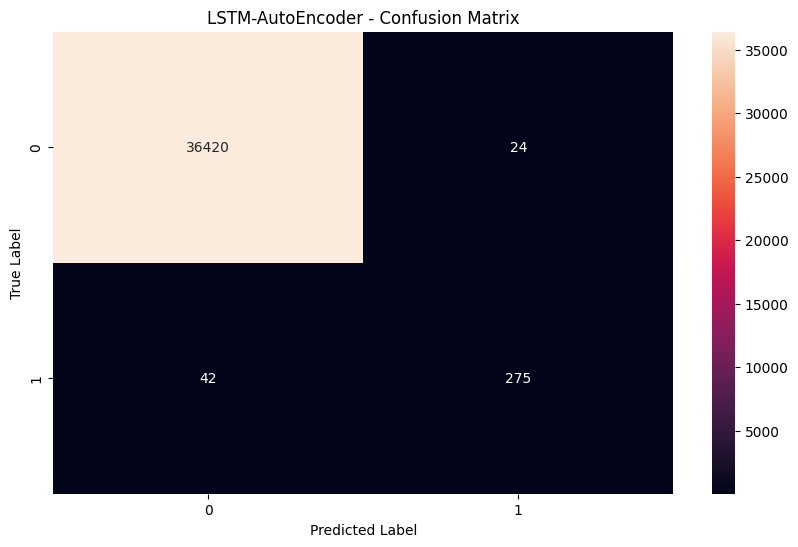

In [6]:
threshold_25S = pick_threshold(y_test_25S, test_mae_25S)

- 15S

nopump_index:  []
nopump_symbol:  []
df.shape:  (213841, 16)
(317,)
df_cleaned.shape:  (213841, 16)
(317,)
deleted:  0
Epoch 1/150
4805/4805 [==============================] - 13s 2ms/step - loss: 0.1560 - val_loss: 0.0716
Epoch 2/150
4805/4805 [==============================] - 9s 2ms/step - loss: 0.0679 - val_loss: 0.0693
Epoch 3/150
4805/4805 [==============================] - 9s 2ms/step - loss: 0.0572 - val_loss: 0.0425
Epoch 4/150
4805/4805 [==============================] - 9s 2ms/step - loss: 0.0409 - val_loss: 0.0403
Epoch 5/150
4805/4805 [==============================] - 9s 2ms/step - loss: 0.0336 - val_loss: 0.0256
Epoch 6/150
4805/4805 [==============================] - 9s 2ms/step - loss: 0.0232 - val_loss: 0.0237
Epoch 7/150
4805/4805 [==============================] - 9s 2ms/step - loss: 0.0212 - val_loss: 0.0223
Epoch 8/150
4805/4805 [==============================] - 10s 2ms/step - loss: 0.0206 - val_loss: 0.0208
Epoch 9/150
4805/4805 [==============================] 

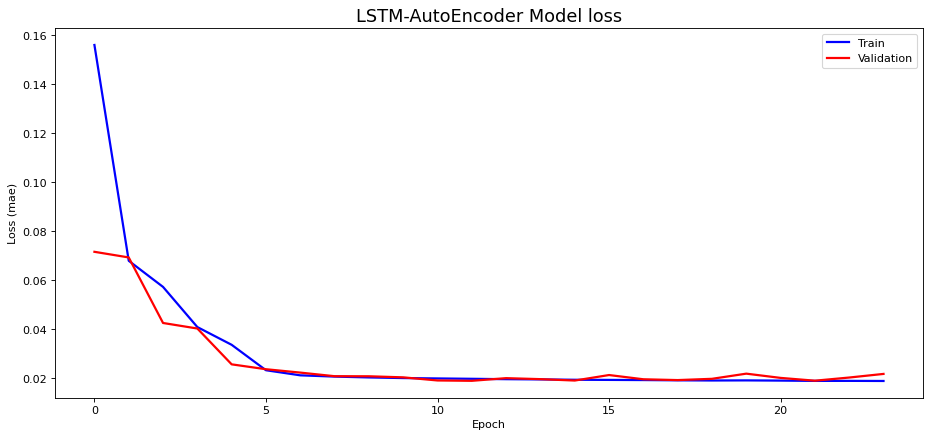

1345/1345 [==============================] - 2s 1ms/step


In [7]:
autoencoder_15S, test_mae_15S, y_test_15S = lstm_autoencoder(time_freq='15S') # 4m 32s

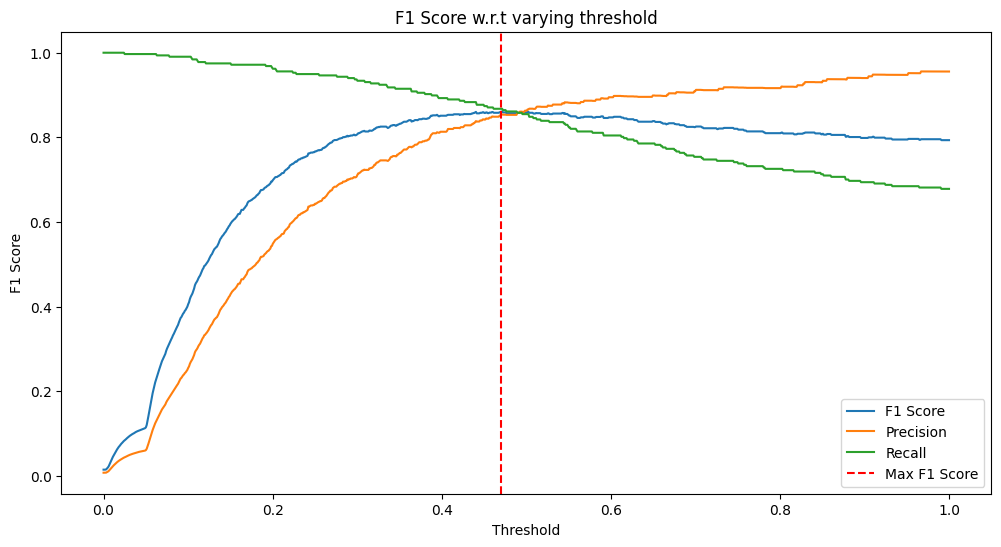

Best threshold:  0.47047047047047047
Best F1 Score:  0.8607198748043818
Recall:  0.8675078864353313
Precision:  0.8540372670807453


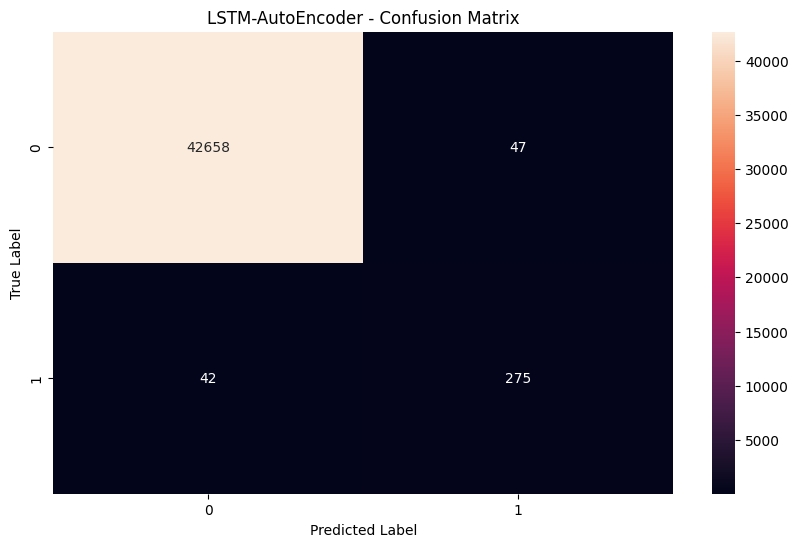

In [8]:
threshold_15S = pick_threshold(y_test_15S, test_mae_15S)

In [14]:
# threshold = threshold_15S
# set_threshold(y_test_15S, test_mae_15S, threshold)

Best threshold:  0.6256256256256256
Best F1 Score:  0.8436482084690554
Recall:  0.8170347003154574
Precision:  0.8720538720538721

- 5S

nopump_index:  []
nopump_symbol:  []
df.shape:  (284236, 16)
(317,)
df_cleaned.shape:  (284236, 16)
(317,)
deleted:  0
Epoch 1/150
6389/6389 [==============================] - 22s 3ms/step - loss: 0.1405 - val_loss: 0.0861
Epoch 2/150
6389/6389 [==============================] - 18s 3ms/step - loss: 0.0629 - val_loss: 0.0522
Epoch 3/150
6389/6389 [==============================] - 19s 3ms/step - loss: 0.0498 - val_loss: 0.0509
Epoch 4/150
6389/6389 [==============================] - 19s 3ms/step - loss: 0.0464 - val_loss: 0.0378
Epoch 5/150
6389/6389 [==============================] - 20s 3ms/step - loss: 0.0299 - val_loss: 0.0306
Epoch 6/150
6389/6389 [==============================] - 19s 3ms/step - loss: 0.0271 - val_loss: 0.0319
Epoch 7/150
6389/6389 [==============================] - 19s 3ms/step - loss: 0.0262 - val_loss: 0.0275
Epoch 8/150
6389/6389 [==============================] - 19s 3ms/step - loss: 0.0257 - val_loss: 0.0306
Epoch 9/150
6389/6389 [==========================

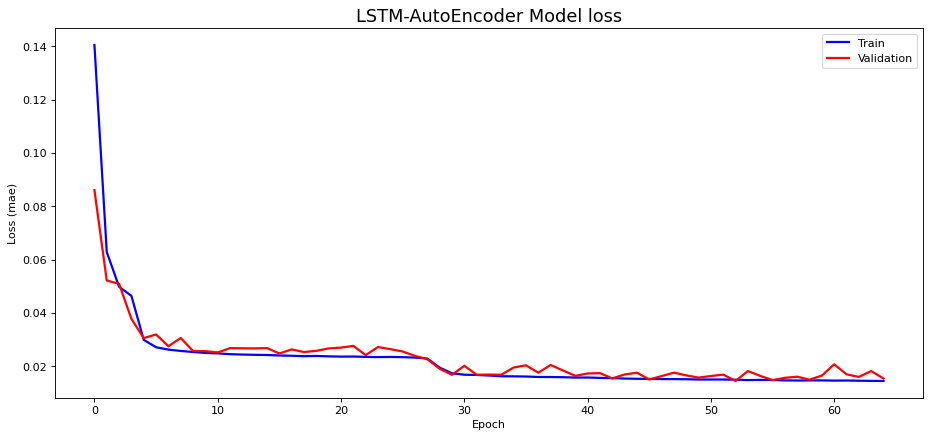

1785/1785 [==============================] - 2s 869us/step


In [9]:
autoencoder_5S, test_mae_5S, y_test_5S = lstm_autoencoder(time_freq='5S')

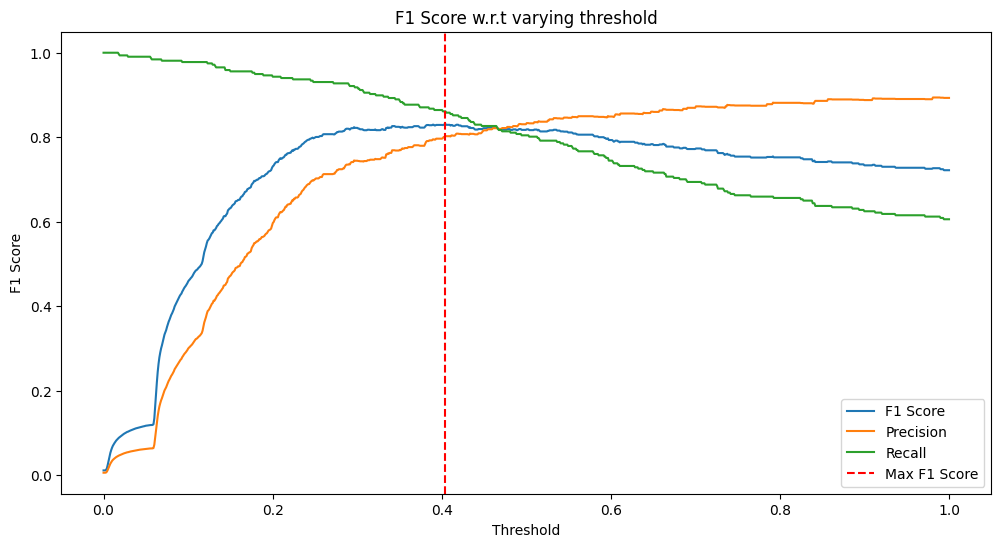

Best threshold:  0.4044044044044044
Best F1 Score:  0.8310502283105022
Recall:  0.861198738170347
Precision:  0.8029411764705883


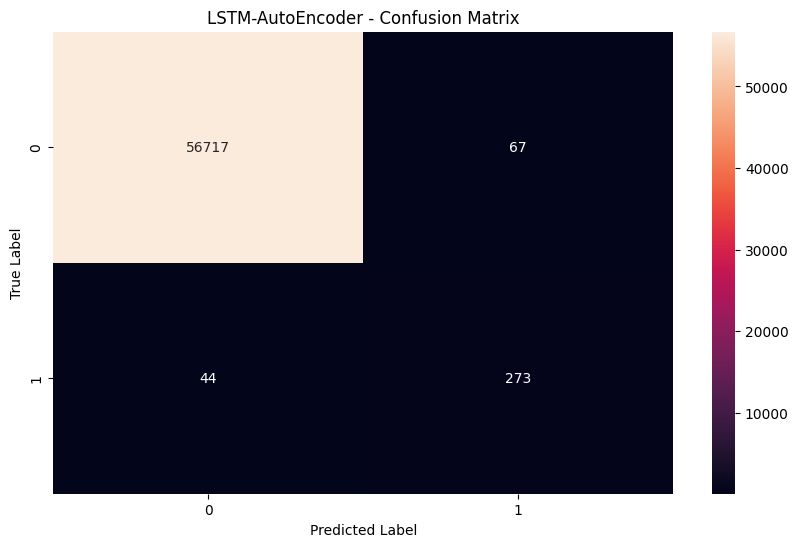

In [10]:
threshold_5S = pick_threshold(y_test_5S, test_mae_5S)

Reconstruction error threshold_5S:  0.4044044044044044
Reconstruction error threshold_15S:  0.47047047047047047
Reconstruction error threshold_25S:  0.38038038038038036
5S: F1 Score: 0.8310502283105022, Recall: 0.861198738170347, Precision: 0.8029411764705883
15S: F1 Score: 0.8607198748043818, Recall: 0.8675078864353313, Precision: 0.8540372670807453
25S: F1 Score: 0.8928571428571429, Recall: 0.8675078864353313, Precision: 0.919732441471572


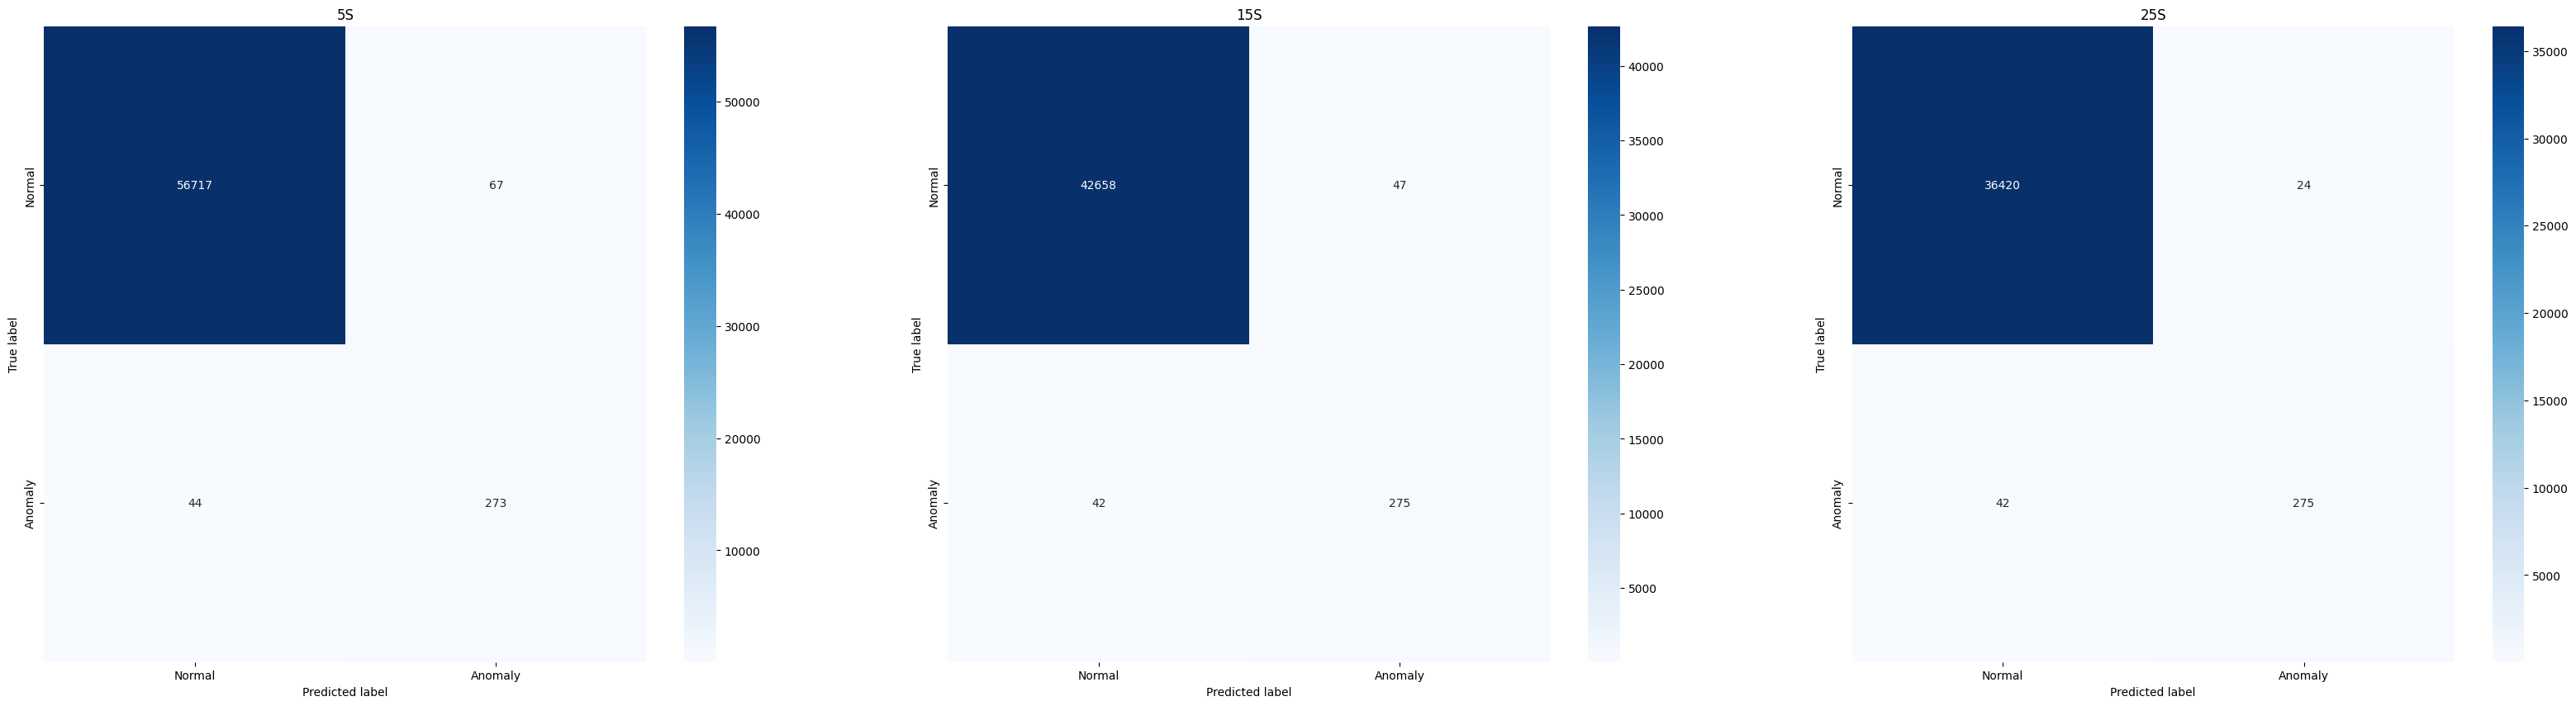

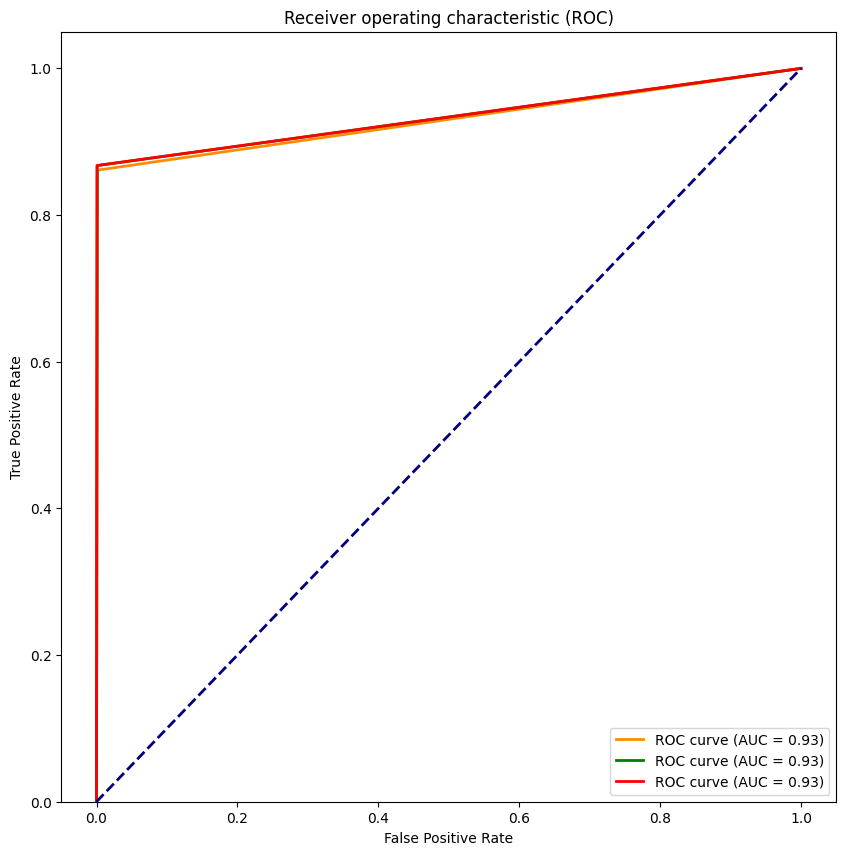

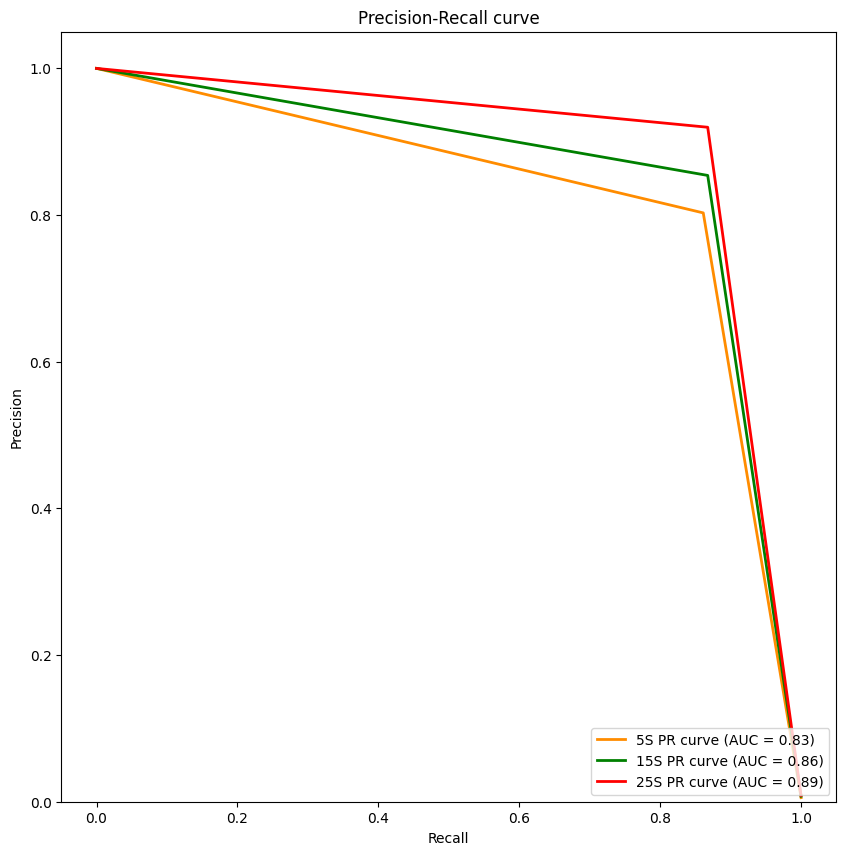

In [26]:
# 设置阈值
print("Reconstruction error threshold_5S: ", threshold_5S)
print("Reconstruction error threshold_15S: ", threshold_15S)
print("Reconstruction error threshold_25S: ", threshold_25S)

# Sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


y_test_pred_5S = np.where(test_mae_5S >= threshold_5S , 1, 0)
y_test_pred_15S = np.where(test_mae_15S >= threshold_15S , 1, 0)
y_test_pred_25S = np.where(test_mae_25S >= threshold_25S , 1, 0)

y_test_prod_5S = sigmoid(y_test_pred_5S)
y_test_prod_15S = sigmoid(y_test_pred_15S)
y_test_prod_25S = sigmoid(y_test_pred_25S)

# precision, recall, f1-score
from sklearn.metrics import f1_score, recall_score, precision_score
F1_score_5S = f1_score(y_test_5S, y_test_pred_5S)
Recall_5S = recall_score(y_test_5S, y_test_pred_5S)
Precision_5S = precision_score(y_test_5S, y_test_pred_5S)

F1_score_15S = f1_score(y_test_15S, y_test_pred_15S)
Recall_15S = recall_score(y_test_15S, y_test_pred_15S)
Precision_15S = precision_score(y_test_15S, y_test_pred_15S)

F1_score_25S = f1_score(y_test_25S, y_test_pred_25S)
Recall_25S = recall_score(y_test_25S, y_test_pred_25S)
Precision_25S = precision_score(y_test_25S, y_test_pred_25S)

print('5S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_5S, Recall_5S, Precision_5S))
print('15S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_15S, Recall_15S, Precision_15S))
print('25S: F1 Score: {}, Recall: {}, Precision: {}'.format(F1_score_25S, Recall_25S, Precision_25S))

# plot confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix_5S = confusion_matrix(y_test_5S, y_test_pred_5S)
confusion_matrix_15S = confusion_matrix(y_test_15S, y_test_pred_15S)
confusion_matrix_25S = confusion_matrix(y_test_25S, y_test_pred_25S)

plt.figure(figsize=(40,10))
plt.subplot(1,3,1)
plt.title('5S')
sns.heatmap(confusion_matrix_5S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,2)
plt.title('15S')
sns.heatmap(confusion_matrix_15S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.subplot(1,3,3)
plt.title('25S')
sns.heatmap(confusion_matrix_25S, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted label')
plt.ylabel('True label')


# plot ROC curve
from sklearn.metrics import roc_curve, auc
# fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_pred_5S)
fpr_5S, tpr_5S, thresholds_5S = roc_curve(y_test_5S, y_test_prod_5S)

roc_auc_5S = auc(fpr_5S, tpr_5S)

# fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_pred_15S)
fpr_15S, tpr_15S, thresholds_15S = roc_curve(y_test_15S, y_test_prod_15S)
roc_auc_15S = auc(fpr_15S, tpr_15S)

# fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_pred_25S)
fpr_25S, tpr_25S, thresholds_25S = roc_curve(y_test_25S, y_test_prod_25S)
roc_auc_25S = auc(fpr_25S, tpr_25S)

plt.figure(figsize=(10,10))
plt.plot(fpr_5S, tpr_5S, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_5S) # lw: line width
plt.plot(fpr_15S, tpr_15S, color='green', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_15S) # lw: line width
plt.plot(fpr_25S, tpr_25S, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc_25S) # lw: line width
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 画对角线
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('False Positive Rate') # x轴标签
plt.ylabel('True Positive Rate') # y轴标签
plt.title('Receiver operating characteristic (ROC)') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()

# plot PR curve
from sklearn.metrics import precision_recall_curve
precision_5S, recall_5S, thresholds_5S = precision_recall_curve(y_test_5S, y_test_prod_5S)
precision_15S, recall_15S, thresholds_15S = precision_recall_curve(y_test_15S, y_test_prod_15S)
precision_25S, recall_25S, thresholds_25S = precision_recall_curve(y_test_25S, y_test_prod_25S)

plt.figure(figsize=(10,10))
plt.plot(recall_5S, precision_5S, color='darkorange', lw=2, label='5S PR curve (AUC = %0.2f)' % auc(recall_5S, precision_5S)) # lw: line width
plt.plot(recall_15S, precision_15S, color='green', lw=2, label='15S PR curve (AUC = %0.2f)' % auc(recall_15S, precision_15S)) # lw: line width
plt.plot(recall_25S, precision_25S, color='red', lw=2, label='25S PR curve (AUC = %0.2f)' % auc(recall_25S, precision_25S)) # lw: line width
# plt.xlim([0.0, 1.0]) # x轴范围
plt.ylim([0.0, 1.05]) # y轴范围
plt.xlabel('Recall') # x轴标签
plt.ylabel('Precision') # y轴标签
plt.title('Precision-Recall curve') # 图片标题
plt.legend(loc="lower right") # 图例
plt.show()


# Reconstruction error threshold_5S:  0.4754754754754755
# Reconstruction error threshold_15S:  0.3843843843843844
# Reconstruction error threshold_25S:  0.38238238238238237
# 5S: F1 Score: 0.718196457326892, Recall: 0.7034700315457413, Precision: 0.7335526315789473
# 15S: F1 Score: 0.8469055374592834, Recall: 0.8201892744479495, Precision: 0.8754208754208754
# 25S: F1 Score: 0.8906497622820919, Recall: 0.886435331230284, Precision: 0.8949044585987261

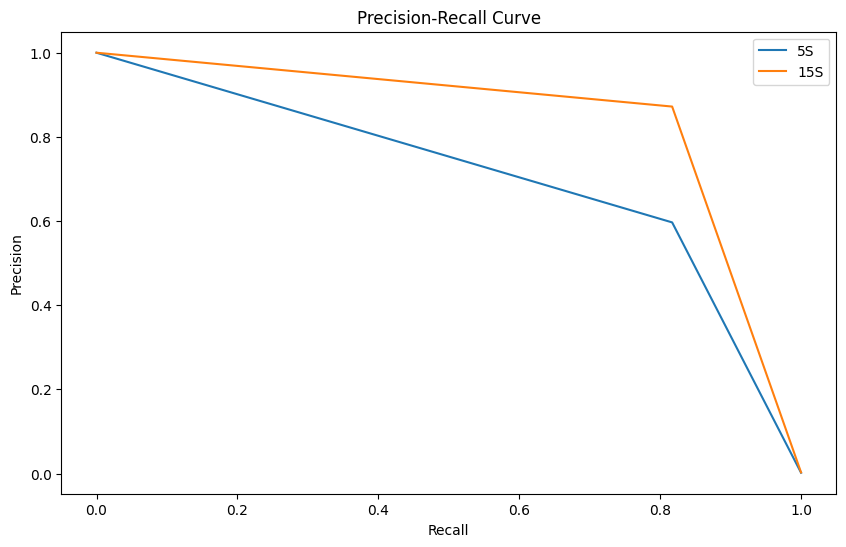

In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 假设你有真实标签和预测分数
# true_labels是实际标签（0表示正常，1表示异常）
# anomaly_scores是异常分数，通常是模型的输出

# 计算精确度、召回率和阈值
precision_5S, recall_5S, thresholds_5S = precision_recall_curve(y_test_5S, y_test_pred_5S) # 5
# precision_10S, recall_10S, thresholds_10S = precision_recall_curve(y_test_10S, y_test_pred_10S) # 10
precision_15S, recall_15S, thresholds_15S = precision_recall_curve(y_test_15S, y_test_pred_15S) # 15


# 绘制精确度-召回率曲线
plt.figure(figsize=(10, 6))
plt.plot(recall_5S, precision_5S, label='5S')
# plt.plot(recall_10S, precision_10S, label='10S')
plt.plot(recall_15S, precision_15S, label='15S')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [ ]:
# threshold = threshold_5S
# set_threshold(y_test_5S, test_mae_5S, threshold_5S)

In [ ]:
# # 设置阈值
# threshold_1 = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)
# threshold_2 = np.mean(test_mae_loss) - 3 * np.std(test_mae_loss)
# print("Reconstruction error threshold: ", threshold_1, threshold_2)
# y_test_pred = np.where((test_mae_loss >= threshold_1) | (test_mae_loss< threshold_2) , 1, 0)

# # precision, recall, f1-score
# print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))

# # plot confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('LSTM-AutoEncoder - Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()